# Analyze trained

In [17]:
import pandas as pd
import os.path
import os
import h5py
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import itertools
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Read data from local
with h5py.File(os.getcwd()+'/data/'+"X.h5","r") as f:
    lcs = np.array(f["X"])
    times = np.array(f["time"])

with h5py.File(os.getcwd()+'/data/'+"Y.h5","r") as f:
    pars = np.array(f["Y"])
    features_names = list([str(val.decode("utf-8")) for val in f["keys"]])

print(f"lcs={lcs.shape}, pars={pars.shape}, times={times.shape}")
print(f"lcs={lcs.min()}, {lcs.max()}, pars={pars.min()} {pars.max()}, times={times.shape}")
print(features_names)

lcs=(43200, 150), pars=(43200, 7), times=(150,)
lcs=4.1156688517299256e-13, 101.53666687011719, pars=0.0 92999999488.0, times=(150,)
['eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq']


In [12]:
# load model
import torch
from model_cvae import CVAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.empty_cache()
    
def load_model(model_file):
    model = CVAE(image_size=len(lcs[0]),  #  150
                 hidden_dim=700,
                 z_dim=4 * len(features_names),
                 c=len(features_names))
    model.to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()
    return model
    
fname = os.getcwd()+'/'+"models/"+"VAE_model_loglr3_batch64.pt"

model = load_model(fname)
df_train = pd.read_csv(fname.replace(".pt","_train_losses.csv"))
df_test = pd.read_csv(fname.replace(".pt","_test_losses.csv"))

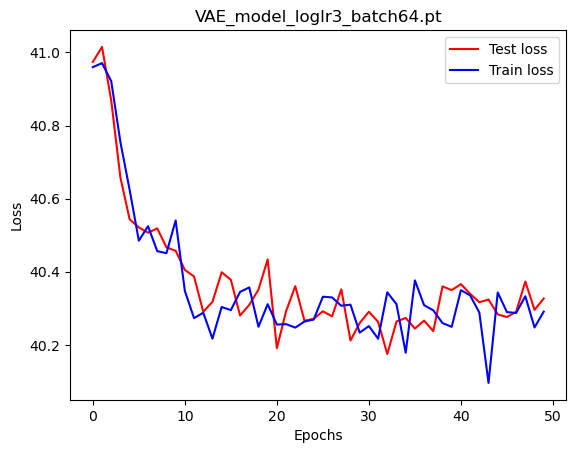

In [13]:
# Plot train/test loss function as a function of time
fig, ax = plt.subplots(ncols=1,nrows=1)
ax.plot(range(df_test.shape[0]),df_test['Loss'],color="red",label="Test loss")
ax.plot(range(df_train.shape[0]),df_train['Loss'],color="blue",label="Train loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title(fname.split('/')[-1])
ax.legend(loc="best")

In [14]:
# inference
from train import LightCurveDataset
dataset = LightCurveDataset(pars, lcs, times)

def inference(pars:list, model:CVAE, dataset:LightCurveDataset, device):
    # if len(pars) != model.z_dim:
    #     raise ValueError(f"Number of parameters = {len(pars)} does not match the model latent space size {model.z_dim}")
    # create state vector for intput data (repeat physical parameters for times needed)
    pars = np.asarray(pars).reshape(1, -1)
    # normalize parameters as in the training data
    normed_pars = dataset._transform_pars(_pars=pars)
    # generate prediction
    with torch.no_grad():
        # convert intput data to the format of the hidden space
        z = (torch.zeros((1, model.z_dim)).repeat((len(normed_pars), 1)).to(device).to(torch.float))
        # create the input for the decoder 
        decoder_input = torch.cat((z, torch.from_numpy(normed_pars).to(device).to(torch.float)), dim=1)
        # perform reconstruction using model
        reconstructions = model.decoder(decoder_input)
    # move prediction to cpu and numpy
    reconstructions_np = reconstructions.double().cpu().detach().numpy()
    # undo normalization that was done in training data
    lc_nn = dataset.inverse_transform_lc_log(reconstructions_np)
    return lc_nn
# 'eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq'
#new_pars = [.1, 0.01, 1., 2.2, 0., 0.01, 2.4e9]
#lc = inference(new_pars, model, dataset, device)

(43200, 7) (7,)
(1, 7) (43200,)


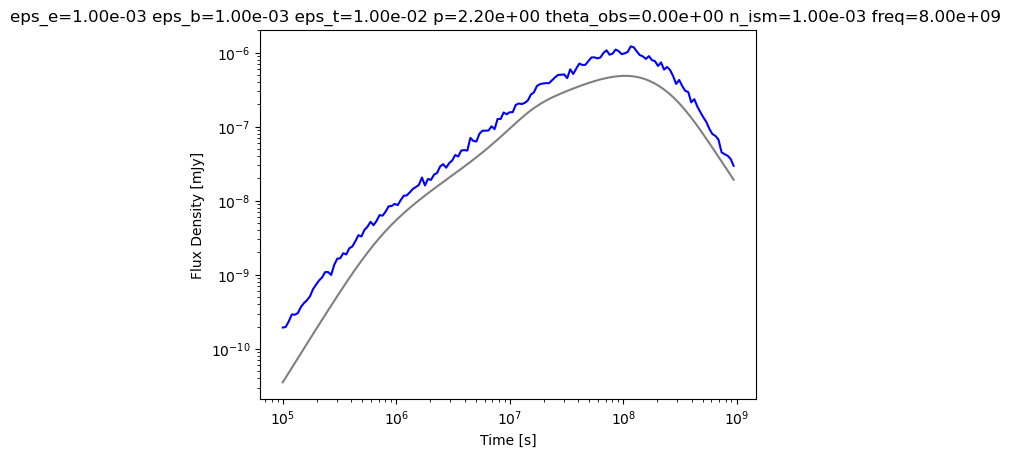

(43200, 7) (7,)
(1, 7) (43200,)


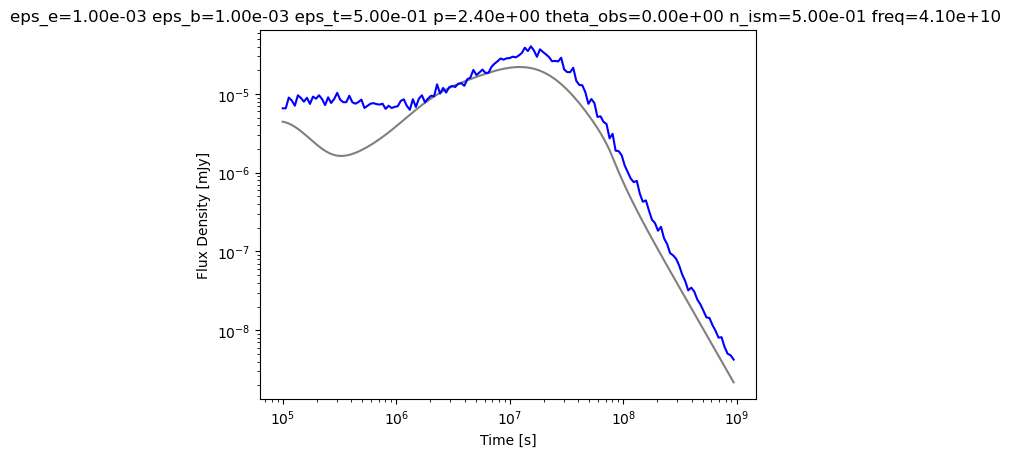

(43200, 7) (7,)
(1, 7) (43200,)


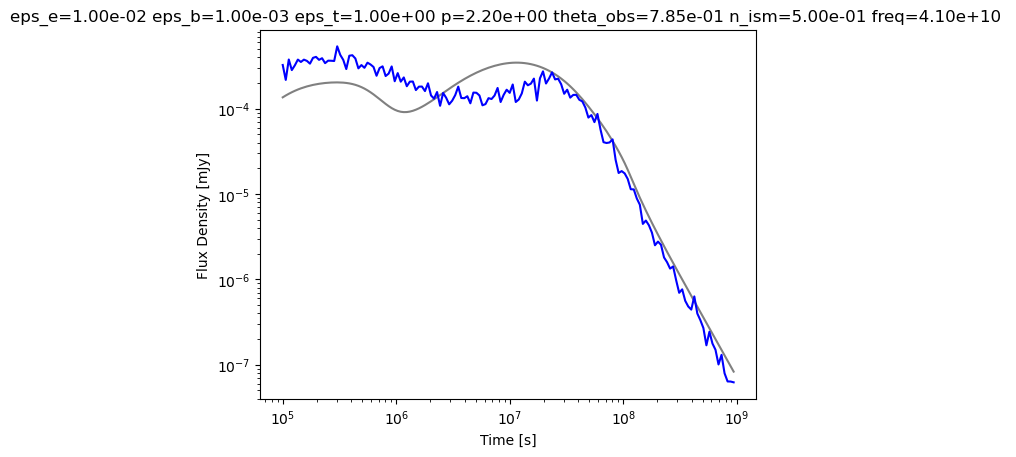

In [15]:
def plot_one(i = 0):

    lc = lcs[i]
    par = pars[i]
    print(pars.shape, par.shape)
    title = "".join([_par+"="+f"{_val:.2e} " for _par,_val in zip(features_names,par)])
    plt.loglog(times, lc, color='gray')

    lc_nn = inference(par, model, dataset, device)
    lc_nn = lc_nn[0]
    plt.ylabel("Flux Density [mJy]")
    plt.xlabel("Time [s]")
    plt.loglog(times, lc_nn, color='blue')
    plt.title(title)
    plt.show()

plot_one(1)
plot_one(1000)
plot_one(10000)

In [ ]:
def evaluate_encoder(model, dataloader, params,
                     n_classes=5, force=False, device='cpu'):
    """Creates a joint plot of features, used during training, figures
    are W&B ready

    Parameters
    ----------
    model      : pytorch obejct
        model to be evaluated
    dataloader : pytorch object
        dataloader object with data to be evaluated with model
    params     : dictionary
        dictionary of model configuration parameters
    n_classes  : int
        number of unique classes/labels availables in the data
    force      : bool, optional
        wheather to force model evaluation or load values from file archive
    device     : str, optional
        device where model runs, gpu or cpu

    Returns
    -------
    mu_df
        Pandas dataframe of mu values, last column are the labels 
    std_df
        Pandas dataframe of std values, last column are the labels 
    """

    fname_mu = '%s/wandb/run-%s-%s/latent_space_mu.txt' % (path,
                                                           params['date'], params['ID'])
    fname_std = '%s/wandb/run-%s-%s/latent_space_std.txt' % (path, params['date'], params['ID'])
    fname_lbs = '%s/wandb/run-%s-%s/labels.txt' % (path, params['date'], params['ID'])
    
    
    if os.path.exists(fname_mu) & os.path.exists(fname_std) & os.path.exists(fname_lbs) &  ~force:
        print('Loading from files...')
        mu = np.loadtxt(fname_mu)
        std = np.loadtxt(fname_std)
        labels = np.loadtxt(fname_lbs, dtype=np.str)

    else:
        print('Evaluating Encoder...')
        time_start = datetime.datetime.now()

        mu, logvar, xhat, labels = [], [], [], []
        with tqdm_notebook(total=len(dataloader)) as pbar:
            for i, (data, label, onehot, pp) in enumerate(dataloader):
                data = data.to(device)
                onehot = onehot.to(device)
                pp = pp.to(device)
                cc = torch.cat([onehot, pp], dim=1)
                if params['label_dim'] > 0 and params['physics_dim'] > 0:
                    mu_, logvar_ = model.encoder(data, label=onehot, phy=pp)
                elif params['label_dim'] > 0 and params['physics_dim'] == 0:
                    mu_, logvar_ = model.encoder(data, label=onehot)
                elif params['label_dim'] == 0:
                    mu_, logvar_ = model.encoder(data)
                else:
                    print('Check conditional dimension...')
                mu.extend(mu_.data.cpu().numpy())
                logvar.extend(logvar_.data.cpu().numpy())
                labels.extend(label)
                torch.cuda.empty_cache()
                pbar.update()
        mu = np.array(mu)
        std = np.exp(0.5 * np.array(logvar))

        #np.savetxt(fname_mu, mu)
        #np.savetxt(fname_std, std)
        #np.savetxt(fname_lbs, np.asarray(labels), fmt='%s')
        elap_time = datetime.datetime.now() - time_start
        print('Elapsed time  : %.2f s' % (elap_time.seconds))
        print('##'*20)

    mu_df = pd.DataFrame(mu)
    std_df = pd.DataFrame(std)

    mu_df['class'] = labels
    std_df['class'] = labels

    return mu_df, std_df

mu, std = evaluate_encoder(vae, dataloader, config,
                           n_classes=num_cls, force=False)

In [ ]:
g = sb.PairGrid(mu,
                hue='class', hue_order=sorted(set(mu.loc[:,'class'].values)),
                corner=False, despine=True, palette='Dark2_r')
g = g.map_diag(plt.hist, histtype='step', lw=1.5)
g = g.map_offdiag(plt.scatter, marker='.', s=20, alpha=.5, edgecolors='none')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g = g.add_legend(loc='upper center', fontsize=20, title='',
                 markerscale=4, ncol=2)
for ax in g.axes.flat:
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')

plt.show()